In [1]:
import time
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as etree

from skimage.transform import resize
from skimage import feature
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
label_dir = 'Datasets/annotations'
image_dir = 'Datasets/images'

list_image = []
list_label = []

for xml_file in os.listdir(label_dir):
    xml_path = os.path.join(label_dir, xml_file)
    
    tree = etree.parse(xml_path)
    root = tree.getroot()
    
    folder = root.find('folder').text
    img_filename = root.find('filename').text
    img_filepath = os.path.join(image_dir, img_filename)
    
    img = cv2.imread(img_filepath)
    if img is None:
        print('Image not found')
        continue
    
    for obj in root.findall('object'):
        classname = obj.find('name').text
        if classname == 'trafficlight':
            continue
        
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)
        
        object_img = img[ymin:ymax, xmin:xmax]
        
        list_image.append(object_img)
        list_label.append(classname)



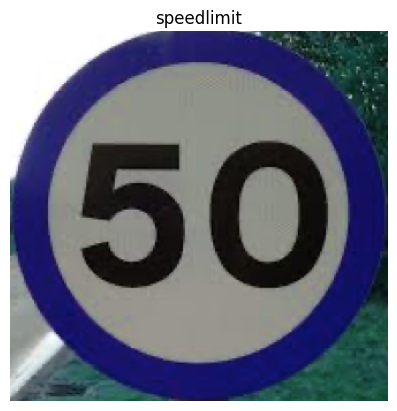

{'stop', 'crosswalk', 'speedlimit'}


In [3]:
plt.imshow(list_image[0])
plt.axis('off')
plt.title(list_label[0])
plt.show()

print(set(list_label))

                                                                PREPROCESSING IMAGE, USING HoG features

In [4]:
def preprocess_image(image):
    if(len(image) > 2):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    image = image.astype(np.float32)

    resized_img = resize(image, output_shape=(32, 32), anti_aliasing=True)

    hog_features = feature.hog(resized_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2',feature_vector=True)

    return hog_features

In [5]:
img_processed_list = []

for img in list_image:
    img_features = preprocess_image(img)
    img_processed_list.append(img_features)

img_processed_list = np.array(img_processed_list)

print(list_image[0].shape)
print(img_processed_list[0].shape)

(321, 328, 3)
(324,)


In [6]:
label_encoder = LabelEncoder()
encoded_label = label_encoder.fit_transform(list_label)

print(encoded_label)

X_train, X_test, y_train, y_test = train_test_split(img_processed_list, encoded_label, test_size=0.3, random_state=42,shuffle=True)

scaler_standard = StandardScaler()
X_train = scaler_standard.fit_transform(X_train)
X_test = scaler_standard.transform(X_test)

model = SVC(kernel='rbf',random_state=42,probability=True,C=0.5)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

[1 1 1 ... 2 2 2]
Accuracy: 0.978328173374613


                                                BUILD FUNCTION OBJECT DETECTION WITH SLIDING WINDOW AND PYRAMID IMAGE

In [7]:
def sliding_window(image, window_sizes, stride):

    image_height, image_width = image.shape[:2]

    windows = []

    for window_size in window_sizes:
        window_width, window_height = window_size
        for y in range(0, image_height - window_height + 1, stride):
            for x in range(0, image_width - window_width + 1, stride):
                windows.append([x, y, x + window_width, y + window_height])

    return windows

def pyramid_image(image, scale=0.8, min_size=(30, 30)):
    first_scale = 1.0
    pyramid_imgs = [(image, first_scale)]

    while True:
        first_scale = first_scale * scale
        h = int(image.shape[0] * first_scale)
        w = int(image.shape[1] * first_scale)
        if h < min_size[1] or w < min_size[0]:
            break

        image = cv2.resize(image, (w, h))
        pyramid_imgs.append((image, first_scale))

    return pyramid_imgs


def draw_rectangle(image, bounding_box, label_encoder):

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for box in bounding_box:
        x1, y1, x2, y2, class_idx, prob = box

        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

        class_name = label_encoder.inverse_transform([class_idx])[0]
        label = f'{class_name}: {prob:.2f}'

        (w,h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1, 1)
        cv2.rectangle(image, (x1, y1), (x1 + w, y1 - h), (255, 0, 0), -1)
        cv2.putText(image, label, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1)

    plt.imshow(image)
    plt.axis('off')
    plt.show()


                                                                TEST

In [8]:
def compute_iou(bbox, bboxes, bbox_area, bboxes_area):
    xxmin = np.maximum(bbox[0], bboxes[:, 0])
    yymin = np.maximum(bbox[1], bboxes[:, 1])
    xxmax = np.minimum(bbox[2], bboxes[:, 2])
    yymax = np.minimum(bbox[3], bboxes[:, 3])
 
    w = np.maximum(0, xxmax-xxmin + 1)
    h = np.maximum(0, yymax-yymin + 1)
 
    intersection = w * h
    iou = intersection / (bbox_area + bboxes_area-intersection)
 
    return iou

In [9]:
def nms(bboxes, iou_threshold):
    if not bboxes:
        return []
    
    scores = np.array([bbox[5] for bbox in bboxes])
    indices = np.argsort(scores)[::-1]

    x1 =  np.array([bbox[0] for bbox in bboxes])
    y1 =  np.array([bbox[1] for bbox in bboxes])
    x2 =  np.array([bbox[2] for bbox in bboxes])
    y2 =  np.array([bbox[3] for bbox in bboxes])

    area = (x2 - x1 + 1) * (y2 - y1 + 1)

    keep = []

    while indices.size > 0:
        i = indices[0]
        keep.append(i)

        iou = compute_iou([x1[i],y1[i],x2[i],y2[i]],
                     np.array([
                         x1[indices[1:]],
                         y1[indices[1:]],
                         x2[indices[1:]],
                         y2[indices[1:]]

                         ]).T,area[i],area[indices[1:]]
                     )     
    
        idx_keep = np.where(iou <= iou_threshold)[0]
        indices = indices[idx_keep + 1]
    return [bboxes[i] for i in keep]
                          

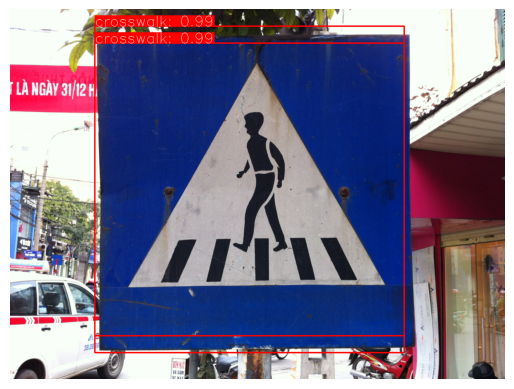

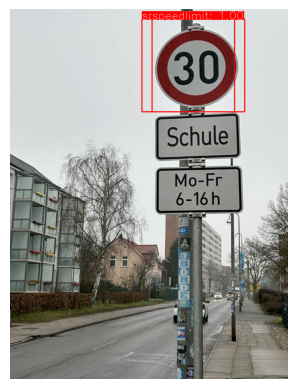

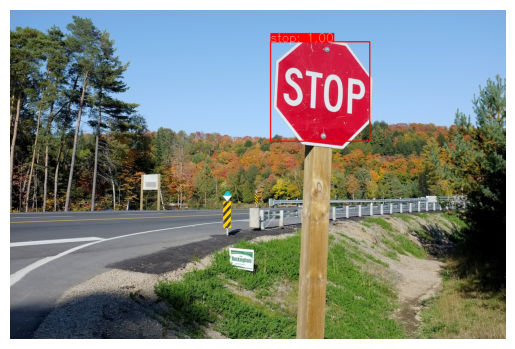

In [10]:
img_test_dir = 'ImageTest'
img_test_list = os.listdir(img_test_dir)[:20]
threadhold = 0.99
stride = 28
window_sizes = [
    (32, 32),
    (64, 64),
    (128, 128),
    (256, 256),
    (512, 512)
]

for img in img_test_list:


    img_file_path = os.path.join(img_test_dir, img)

    bounding_box = []
    image = cv2.imread(img_file_path)
    pyramid_images = pyramid_image(image)
    for pyramid_info in pyramid_images:
        pyramid_img, scale = pyramid_info

        window_list = sliding_window(pyramid_img, window_sizes, stride)
        for window in window_list:
            x1, y1, x2, y2 = window
            window_img = pyramid_img[y1:y2, x1:x2]

            preprocess_img = preprocess_image(window_img)

            normalize_img = scaler_standard.transform([preprocess_img])[0]

            label = model.predict_proba([normalize_img])[0]

            if np.all(label < threadhold):
                continue
            else:
                class_idx = np.argmax(label)
                prob = label[class_idx]

                x1 = int(x1 / scale)
                y1 = int(y1 / scale)
                x2 = int(x2 / scale)
                y2 = int(y2 / scale)

                bounding_box.append([x1, y1, x2, y2, class_idx, prob])
    nms(bounding_box,0.01)
    draw_rectangle(image, bounding_box, label_encoder)
    